In [25]:
#libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import time
import pickle
from datetime import datetime, timedelta
from yahoo_fin.stock_info import get_data
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

#  Determining Cryptos for Analysis

In [2]:
# getting TODAY's date
today = datetime.strftime(datetime.today(), "%m%d%y")

In [3]:
# defining function to read data from a given url
def getdata(url):
    r = requests.get(url,headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
    data = pd.read_html(r.text)
    return data

In [4]:
# defining function to get top 500 cryptos by marketcap off yahoo finance
def crypto_meta_marketcap(n_count=500):
    home = 'https://finance.yahoo.com/cryptocurrencies/'
    count = 100
    n_offset = n_count//count
    
    cryptos = None
    for o in range(n_offset):
        url = f'{home}?offset={o*100}&count={count}'
        df = getdata(url)[0]
        if cryptos is None:
            cryptos = pd.DataFrame(index=range(n_count), columns=df.columns)
        # print(cryptos, cryptos.loc[o*count:(o+1)*count], df, df.values)
        # print(len(cryptos), len(df.values))
        cryptos.iloc[o*count:(o+1)*count] = df
        
    return cryptos

In [5]:
# make function to give you a dictionary with symbol and close prices for each crypto for the entire analysis time
# start and end date as string 'm/d/y'
# time interval as string ex: '1wk'
def analysisdata(symbols, startdate, enddate, tinterval):
    series = dict()
    for i in symbols:
        series[i] = get_data(i, start_date=startdate, end_date=enddate, index_as_date=True, interval=tinterval)['close']
    return series

In [350]:
# return a df of those top 500 cryptos
c = crypto_meta_marketcap()
c.head()

,Symbol,Name,Price (Intraday),Change,% Change,Market Cap,Volume in Currency (Since 0:00 UTC),Volume in Currency (24Hr),Total Volume All Currencies (24Hr),Circulating Supply,52 Week Range,Day Chart
0,BTC-USD,Bitcoin USD,19240.26,-240.54,-1.23%,368.942B,26.768B,26.768B,26.768B,19.176M,NaN,NaN
1,ETH-USD,Ethereum USD,1306.01,-15.39,-1.16%,160.298B,8.408B,8.408B,8.408B,122.739M,NaN,NaN
2,USDT-USD,Tether USD,1.0,-0.0001,-0.01%,68.373B,36.074B,36.074B,36.074B,68.372B,NaN,NaN
3,USDC-USD,USD Coin USD,1.0001,0.0001,+0.01%,46.073B,3.087B,3.087B,3.087B,46.067B,NaN,NaN
4,BNB-USD,BNB USD,274.92,-3.34,-1.20%,44.355B,635.365M,635.365M,635.365M,161.337M,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
495,UPP-USD,Sentinel Protocol USD,0.061482,-0.001003,-1.60%,28.272M,1.333M,1.333M,1.333M,459.835M,NaN,NaN
496,BLZ-USD,Bluzelle USD,0.082574,-0.001225,-1.46%,28.158M,2.795M,2.795M,2.795M,341M,NaN,NaN
497,AE-USD,Æternity USD,0.080333,0.001329,+1.68%,28.152M,108460,108460,108460,350.442M,NaN,NaN
498,TRU1-USD,TrueFi USD,0.0512,0.000174,+0.34%,28.106M,1.683M,1.683M,1.683M,548.956M,NaN,NaN


In [353]:
# get their date of inception by seeing when their first price entry was. Note that this is moreso the first time
# yahoo fin has data for them, but for the purposes of the analysis it doesn't matter
inception = [get_data(symbol, start_date='091714', end_date=today, index_as_date=True, interval='1wk').index[0] for symbol in c['Symbol']]
c['inception'] = inception
c[['Symbol', 'inception']]

,Symbol,inception
0,BTC-USD,2014-09-15
1,ETH-USD,2017-11-06
2,USDT-USD,2017-11-06
3,USDC-USD,2018-10-08
4,BNB-USD,2017-11-06
...,...,...
495,UPP-USD,2018-06-18
496,BLZ-USD,2018-02-05
497,AE-USD,2017-11-06
498,TRU1-USD,2020-11-16


In [8]:
# seeing how old cryptos are in order to determine our analysis total times time (in years)
c['age'] = ((datetime.today() - c['inception']).dt.days)/365

(array([ 3.,  6.,  5., 12., 14., 19., 16., 16., 21., 25., 13., 33., 32.,
        22., 14., 10.,  7., 11.,  9., 16., 20., 11., 10.,  7., 11.,  7.,
        14.,  5., 16., 14., 78.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([0.02739726, 0.18734247, 0.34728767, 0.50723288, 0.66717808,
        0.82712329, 0.98706849, 1.1470137 , 1.3069589 , 1.46690411,
        1.62684932, 1.78679452, 1.94673973, 2.10668493, 2.26663014,
        2.42657534, 2.58652055, 2.74646575, 2.90641096, 3.06635616,
        3.22630137, 3.38624658, 3.54619178, 3.70613699, 3.86608219,
        4.0260274 , 4.1859726 , 4.34591781, 4.50586301, 4.66580822,
        4.82575342, 4.98569863, 5.14564384, 5.30558904, 5.46553425,
        5.62547945, 5.78542466, 5.94536986, 6.10531507, 6.26526027,
        6.42520548, 6.58515068, 6.74509589, 6.9050411 , 7.0649863 ,
        7.22493151, 7.38487671, 7.54482192, 7.70476712, 7.86471233,
        8.02465753]),
 <BarContainer

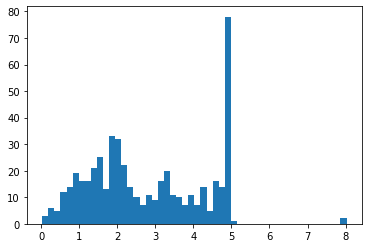

In [9]:
# plotting ages to determine decent value of total analysis time
plt.hist(c['age'].array, bins=50)

In [10]:
# From the graph we see that we can get a good amount of cryptos that are "older" than 4 years, take these
years = 4
crypstoclean = c[c['age'] > years]['Symbol'].reset_index(drop=True)

In [12]:
# turn dictionary into a DataFrame
# use entire analysis time to determine which we symbols we will use
crypstocleandata = pd.DataFrame.from_dict(analysisdata(crypstoclean, '091718', today, '1wk'))

In [13]:
# array of which cryptos to drop from data (mean has to be greater than 1.01 or less than .98 
# over the entire time to not be considered stable coin)
drop = (crypstocleandata.mean()<.98).array + (crypstocleandata.mean()>1.01).array
crypstocleandata.head()

,BTC-USD,ETH-USD,USDT-USD,BNB-USD,XRP-USD,ADA-USD,DOGE-USD,TRX-USD,ETC-USD,LTC-USD,...,RFR-USD,UPP-USD,BCD-USD,PIVX-USD,ELA-USD,SBD-USD,PRE-USD,MONA-USD,BLZ-USD,GRS-USD
2018-09-17,6710.629883,244.330002,0.999512,10.28060,0.570689,0.089754,0.005901,0.023791,11.59860,61.366402,...,0.004136,0.027492,2.06767,0.977504,7.35875,1.025670,0.095707,1.37821,0.128594,0.578899
2018-09-24,6625.560059,232.848007,1.000360,10.01780,0.581572,0.085195,0.005906,0.022165,11.33200,61.141899,...,0.004403,0.026501,1.94940,1.111900,7.13009,1.011630,0.080757,1.33755,0.128123,0.559743
2018-10-01,6602.950195,226.119003,0.996617,10.51900,0.482039,0.084658,0.005562,0.026875,10.89810,58.160301,...,0.004507,0.026545,1.95133,1.073080,7.94287,0.983768,0.055097,1.15220,0.131439,0.550885
2018-10-08,6290.930176,195.714996,0.989570,9.49674,0.403286,0.071293,0.005158,0.023622,9.40812,52.187401,...,0.004916,0.028331,1.70589,1.111680,8.10389,1.015540,0.056346,1.15861,0.119386,0.540607
2018-10-15,6482.350098,205.141998,0.983548,9.74330,0.456694,0.075873,0.004517,0.024196,9.64013,52.915798,...,0.005640,0.027628,1.72449,1.305840,8.90458,1.001930,0.062904,1.15259,0.131991,0.544585


In [16]:
# final list with cryptos for analysis
cryptos = list(crypstocleandata.loc[:, drop ].columns)
cryptos

['BTC-USD',
 'ETH-USD',
 'BNB-USD',
 'XRP-USD',
 'ADA-USD',
 'DOGE-USD',
 'TRX-USD',
 'ETC-USD',
 'LTC-USD',
 'LINK-USD',
 'XLM-USD',
 'XMR-USD',
 'BCH-USD',
 'VET-USD',
 'FIL-USD',
 'XTZ-USD',
 'MANA-USD',
 'QNT-USD',
 'EOS-USD',
 'THETA-USD',
 'KCS-USD',
 'ZEC-USD',
 'MIOTA-USD',
 'HT-USD',
 'MKR-USD',
 'NEO-USD',
 'SNX-USD',
 'NEXO-USD',
 'ENJ-USD',
 'BAT-USD',
 'DASH-USD',
 'WAVES-USD',
 'ZIL-USD',
 'RVN-USD',
 'LRC-USD',
 'CEL-USD',
 'BTG-USD',
 'XEM-USD',
 'DCR-USD',
 'HOT1-USD',
 'XDC-USD',
 'GNO-USD',
 'QTUM-USD',
 'IOTX-USD',
 'GLM-USD',
 'FLUX-USD',
 'RPL-USD',
 'OMG-USD',
 'ZRX-USD',
 'IOST-USD',
 'ICX-USD',
 'ONT-USD',
 'STORJ-USD',
 'WAXP-USD',
 'SC-USD',
 'POLY-USD',
 'VGX-USD',
 'ZEN-USD',
 'ERG-USD',
 'CHSB-USD',
 'DGB-USD',
 'CVC-USD',
 'MED-USD',
 'LSK-USD',
 'EURS-USD',
 'CEEK-USD',
 'SYS-USD',
 'REN-USD',
 'SNT-USD',
 'MAID-USD',
 'ONG1-USD',
 'XNO-USD',
 'MVL-USD',
 'REQ-USD',
 'RLC-USD',
 'ARDR-USD',
 'DENT-USD',
 'POWR-USD',
 'UQC-USD',
 'XYO-USD',
 'NMR-USD',
 '

In [6]:
cryptos = ['BTC-USD',
 'ETH-USD',
 'BNB-USD',
 'XRP-USD',
 'ADA-USD',
 'DOGE-USD',
 'TRX-USD',
 'ETC-USD',
 'LTC-USD',
 'LINK-USD',
 'XLM-USD',
 'XMR-USD',
 'BCH-USD',
 'VET-USD',
 'FIL-USD',
 'XTZ-USD',
 'MANA-USD',
 'QNT-USD',
 'EOS-USD',
 'THETA-USD',
 'KCS-USD',
 'ZEC-USD',
 'MIOTA-USD',
 'HT-USD',
 'MKR-USD',
 'NEO-USD',
 'SNX-USD',
 'NEXO-USD',
 'ENJ-USD',
 'BAT-USD',
 'DASH-USD',
 'WAVES-USD',
 'ZIL-USD',
 'RVN-USD',
 'LRC-USD',
 'CEL-USD',
 'BTG-USD',
 'XEM-USD',
 'DCR-USD',
 'HOT1-USD',
 'XDC-USD',
 'GNO-USD',
 'QTUM-USD',
 'IOTX-USD',
 'GLM-USD',
 'FLUX-USD',
 'RPL-USD',         
 'OMG-USD',
 'ZRX-USD',
 'IOST-USD',
 'ICX-USD',
 'ONT-USD',
 'STORJ-USD',
 'WAXP-USD',
 'SC-USD',
 'POLY-USD',
 'VGX-USD',
 'ZEN-USD',
 'ERG-USD',
 'CHSB-USD',
 'DGB-USD',
 'CVC-USD',
 'MED-USD',
 'LSK-USD',
 'EURS-USD',
 'CEEK-USD',
 'SYS-USD',
 'REN-USD',
 'SNT-USD',
 'MAID-USD',
 'ONG1-USD',
 'XNO-USD',
 'MVL-USD',
 'REQ-USD',
 'RLC-USD',
 'ARDR-USD',
 'DENT-USD',
 'POWR-USD',
 'UQC-USD',
 'XYO-USD',
 'NMR-USD',
 'BNT-USD',
 'STEEM-USD',
 'DAG-USD',
 'TEL-USD',
 'QKC-USD',
 'FUN-USD',
 'REP-USD',
 'STRAX-USD',
 'LOOM-USD',
 'MTL-USD',
 'XWC-USD',
 'STMX-USD',
 'REV1-USD',
 'ADS-USD',
 'ELF-USD',
 'VERI-USD',
 'VTHO-USD',
 'ANT-USD',
 'NKN-USD',
 'TRAC-USD',
 'AGIX-USD',
 'ETN-USD',
 'PRO-USD',
 'IQ-USD',
 'ARK-USD',
 'XVG-USD',
 'UTK-USD',
 'MFT-USD',
 'DERO-USD',
 'CXO-USD',
 'GXC-USD',
 'TIME-USD',
 'MLN-USD',
 'TOMO-USD',
 'AVA-USD',
 'CENNZ-USD',
 'WAN-USD',
 'KMD-USD',
 'BTS-USD',
 'FIRO-USD',
 'BMX-USD',
 'AOG-USD',
 'MOC-USD',
 'RFR-USD',
 'UPP-USD',
 'BCD-USD',
 'PIVX-USD',
 'ELA-USD',
 'SBD-USD',
 'PRE-USD',
 'MONA-USD',
 'BLZ-USD',
 'GRS-USD']

# Get all R matrices (data) for Cryptos from Yahoo Finance

In [7]:
# get n R matrices for our crypto symbols, input a start/end date as a string 'mdy', input epoch in integer days
# function calculates number n of matrices it will make (be careful must check it is an integer beforehand)
# initializes an empty array
# loops through starting at the original start date and gives a dictionary which we turn into a dataframe
# once a dataframe we perform some math operators and drop the first row (returns NaN values)
# then becomes R dataframe (matrix) and we append it to our array
# Does this for the entire data time and then returns the list of all the matrices
# note; here we make our R matrix have 1 day time intervals between data points 
# overlap is how much the corr matrices will overlap value from 0 to 1 (no overlap to no movement [dont use 1 ever])
def rmatrices(startdate, enddate, epoch, overlap, cryptosymbols):
    start_time = time.time()
    n = int((datetime.strptime(enddate, '%m%d%y') - datetime.strptime(startdate, '%m%d%y')).days/epoch)
    matrices = list()
    print('expected number of matrices:', 2*n)
    for i in range(2*n):
        print("Working on generating matrix:", i)
        #tempa_time = time.time()
        tempdict = analysisdata(cryptosymbols, datetime.strftime(datetime.strptime(startdate, '%m%d%y') + timedelta(days = i*(epoch-(overlap*epoch))), '%m%d%y'), datetime.strftime(datetime.strptime(startdate, '%m%d%y') + timedelta(days= epoch + (i * (epoch -(overlap*epoch)))), '%m%d%y'), tinterval= '1d')
        tempdf = pd.DataFrame.from_dict(tempdict)
        tempdftwo = np.log(tempdf).diff()
        r = tempdftwo.drop(index=tempdftwo.index[0])
        matrices.append(r)
        #print("This took %s seconds" % (time.time() - tempa_time))
    print("Total run time was %s seconds" % (time.time() - start_time))
    return matrices

In [8]:
# generate all R matrices in a list
# rmatrix = rmatrices('091718','091722',20, .5, cryptos)
# Got the return matrix data saved as a file using Pickle
fd = open('returndata', "rb")
rmatrix = pickle.load(file)
file.close()

expected number of matrices: 146
Working on generating matrix: 0
Working on generating matrix: 1
Working on generating matrix: 2
Working on generating matrix: 3
Working on generating matrix: 4
Working on generating matrix: 5
Working on generating matrix: 6
Working on generating matrix: 7
Working on generating matrix: 8
Working on generating matrix: 9
Working on generating matrix: 10
Working on generating matrix: 11
Working on generating matrix: 12
Working on generating matrix: 13
Working on generating matrix: 14
Working on generating matrix: 15
Working on generating matrix: 16
Working on generating matrix: 17
Working on generating matrix: 18
Working on generating matrix: 19
Working on generating matrix: 20
Working on generating matrix: 21
Working on generating matrix: 22
Working on generating matrix: 23
Working on generating matrix: 24
Working on generating matrix: 25
Working on generating matrix: 26
Working on generating matrix: 27
Working on generating matrix: 28
Working on generatin

## Determining Correct Number of K-Clusters and Noise Supression

In [78]:
# function which does power mapping for noise supresion, takes corr matrices and replaces each element by
# sign(C_ij)|C_ij|^(1+e)
def noisesupression(corrmatrices, e):
    for df in corrmatrices:
        for i,j in itertools.product(range(len(df.index)), range(len(df.columns))):
            df.iloc[i,j] = math.copysign(1,df.iloc[i,j])* abs((df.iloc[i,j]))**(1+e)
    return corrmatrices


In [80]:
# Function to get similarity matrix from noise supressed correlation matrices
def getsimmatrix(supcorrmatrix):
    emptymat= np.ndarray(shape=(len(supcorrmatrix),len(supcorrmatrix)), dtype=float)
    print("matrix shape:",emptymat.shape)
    for i, j in itertools.product(range(len(supcorrmatrix)), range(len(supcorrmatrix))):
        emptymat[i,j] = abs(supcorrmatrix[i] - supcorrmatrix[j]).mean().mean()
    
    return emptymat

In [175]:
# function to get the average (of averages) of intra-cluster distances for a similarity matrix that has 
# been transformed by MDS for 1 run of k-means clustering
def intraclusterdist(simtrans, kclusters):
    emptydict = {}
    avgstd = {}
    totals = []
    km = KMeans(n_clusters = kclusters, init ='random')
    y_km = km.fit_predict(simtrans)
    # make dictionary with cluster as key and all distances as values (array)
    for i in range(len(simtrans)):
        emptydict.setdefault(y_km[i], []).append(math.sqrt(sum((simtrans[i] - km.cluster_centers_[y_km[i]])**2)))
    # take the dictionary from above and get a new dictionary with cluster as key
    # and a value of [# of points in cluster, average distance, std]
    for key in emptydict:
        avg = sum(emptydict[key])/len(emptydict[key])
        avgstd.setdefault(key,[]).append(len(emptydict[key]))
        avgstd.setdefault(key, []).append(avg)
    # now get weighted average (of average) intracluster distance and avg std (for unequal sample size)
    avgavgdis = 0 
    for key in avgstd:
        avgavgdis += (avgstd[key][0]*avgstd[key][1])/len(simtrans)
    
    return avgavgdis #, avgavgstd
        

In [199]:
# Function to do 500 runs of kmeans cluster for a given choice of k and a similarity matrix
# Given that no random_state seed is fed to the KMeans algo, we will have different random intial conditions
# for centroid initialization of our 500 runs
# This will get the total average distance and std of intracluster distance over 500 runs
def multikrun(simtrans, nruns, kclusters):
    avgsdict = {}
    std = [] 
    for i in range(nruns):
        emp = intraclusterdist(simtrans, kclusters)
        avgsdict.setdefault('avgd', []).append(emp)
        #avgsdict.setdefault('avgstd', []).append(emp[1])
    totalaveragedis = sum(avgsdict['avgd'])/nruns
    for i in avgsdict['avgd']:
        std.append((i - totalaveragedis)**2)
    totalaveragestd = math.sqrt(sum(std)/nruns)
    
    return totalaveragedis, totalaveragestd
        

In [177]:
# function that gives a list of the avg intracluster dist and std for all values of k from 1 to highestk
# will use this to plot
def getkruns(simtrans, highestk):
    dlist = []
    stdlist = []
    for i in range(1,highestk+1):
        temp = multikrun(simtrans, nruns=500, kclusters = i)
        dlist.append(temp[0])
        stdlist.append(temp[1])
    return dlist , stdlist

In [205]:
# function that shows STD ratios from consecutive k values (to discern correct number of states)
def showstdratios(resultsfrommultik):
    for i in range(len(resultsfrommultik[1])-1):
        print("k =", i+2,"divded by k=", i+1)
        print((resultsfrommultik[1][i+1]/resultsfrommultik[1][i])*100)

In [346]:
# function that puts everything together
def ultimate(rmatrix, epsilon):
    start_time = time.time()
    # initialize a list that will have length of epsilon, each entry should be a list of two elements, one of avg
    # distance per k value and one of std of avg dist for that k value
    hold = []
    # for each noise supression parameter
    for ep in epsilon:
        print('Noise supression is', ep)
        # initialize your un-noise supressed correlation matrices
        corrmatrix = [i.corr(method='pearson') for i in rmatrix]
        # then noise supress it
        supcorrmatrix = noisesupression(corrmatrix, ep)
        # then get similarity matrix
        simmatrix = getsimmatrix(supcorrmatrix)
        # then do MDS on it
        mds = MDS(n_components = 3, dissimilarity = 'precomputed')
        simtrans = mds.fit_transform(simmatrix)
        # then do 500 runs of k means for k={1,10}
        result = getkruns(simtrans, 10)
        # add results to list so we can check back on them later
        hold.append(result)
        # discern best k from result
        print(result[1])
        showstdratios(result)
        # plot <D> vs k
        ax5 =plt.gca()
        ax5.set_ylim([0.02, .22])
        ax5.set_xlim([1, 10])
        plt.errorbar(np.arange(1,11), result[0], result[1], linestyle='--',elinewidth=8, barsabove=True)
        plt.title('Cryptocurrency Market (\u03B5 = %1.1f )' %ep )
        plt.ylabel('Average Intracluster Distance')
        plt.xlabel('Number of clusters (k)')
        plt.locator_params(nbins=11)
        plt.show()
    print("This took %s seconds " % (time.time() - start_time))
    return hold

Noise supression is 0.0
matrix shape: (146, 146)
[1.1102230246251565e-16, 1.7763568394002505e-15, 0.00031947423058632844, 0.00040036977931678236, 0.00036002803105222614, 0.0004524486198524038, 0.00041019309995392935, 0.000528062545442785, 0.0006473873368995558, 0.000614562919059953]
k = 2 divded by k= 1
1600.0
k = 3 divded by k= 2
17984800322788.31
k = 4 divded by k= 3
125.32146288668949
k = 5 divded by k= 4
89.92387778782953
k = 6 divded by k= 5
125.67038697794368
k = 7 divded by k= 6
90.66070310651872
k = 8 divded by k= 7
128.73511170765525
k = 9 divded by k= 8
122.59671557593921
k = 10 divded by k= 9
94.92970962379272


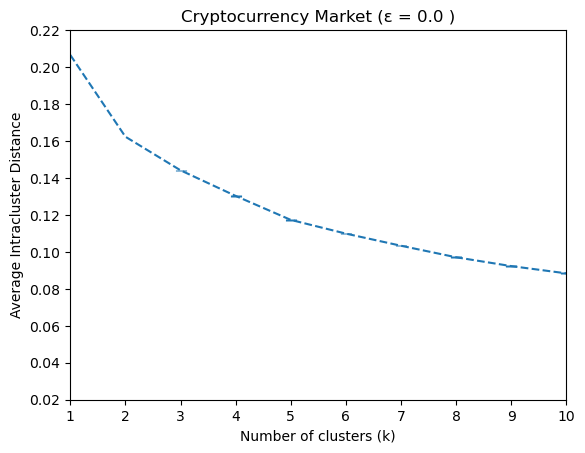

Noise supression is 0.1
matrix shape: (146, 146)
[2.275957200481571e-15, 9.159339953157541e-16, 0.0001847675467891677, 0.0003799119868422613, 0.00030141451767599643, 0.0002772864800955011, 0.00038447736207079694, 0.0005225216090130484, 0.0004429070424213405, 0.0004928279985318237]
k = 2 divded by k= 1
40.243902439024396
k = 3 divded by k= 2
20172583148360.152
k = 4 divded by k= 3
205.61618825613715
k = 5 divded by k= 4
79.33798566907106
k = 6 divded by k= 5
91.99506454880463
k = 7 divded by k= 6
138.65708920910168
k = 8 divded by k= 7
135.90438880425742
k = 9 divded by k= 8
84.76339251460129
k = 10 divded by k= 9
111.27120396134795


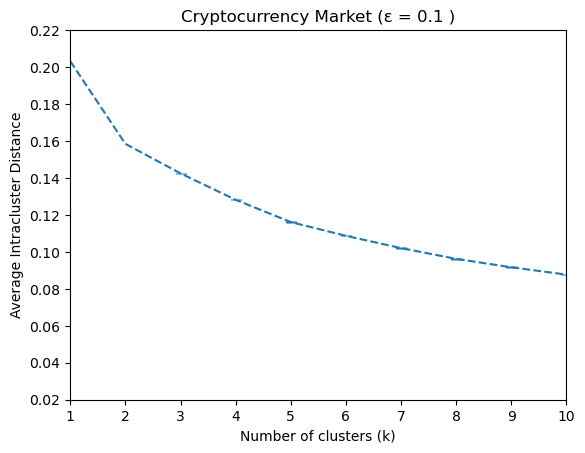

Noise supression is 0.2
matrix shape: (146, 146)
[3.885780586188048e-16, 3.4857297847780896e-07, 0.00016085850292090034, 0.00025660065226465305, 0.00033519061317067533, 0.0003256311888099674, 0.0004521078079335537, 0.000477535659750884, 0.0005557757718046353, 0.0006531840230756441]
k = 2 divded by k= 1
89704750627.66197
k = 3 divded by k= 2
46147.7259721499
k = 4 divded by k= 3
159.51948302716232
k = 5 divded by k= 4
130.62734260899933
k = 6 divded by k= 5
97.14806322579194
k = 7 divded by k= 6
138.84045001518444
k = 8 divded by k= 7
105.62428946616808
k = 9 divded by k= 8
116.38414021155337
k = 10 divded by k= 9
117.52653789759829


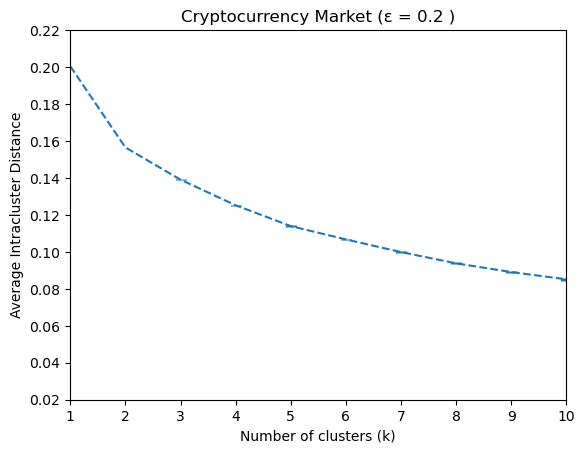

Noise supression is 0.30000000000000004
matrix shape: (146, 146)
[1.6375789613221059e-15, 3.677922862767866e-06, 0.00031671968109179237, 0.0002010209661553209, 0.0001424996630073538, 0.0004186374041403571, 0.0004033385582609365, 0.0004893434333217016, 0.0005304418344961316, 0.0005360693763844124]
k = 2 divded by k= 1
224595146227.2378
k = 3 divded by k= 2
8611.373672297223
k = 4 divded by k= 3
63.46967939041988
k = 5 divded by k= 4
70.88796046142272
k = 6 divded by k= 5
293.7813292363737
k = 7 divded by k= 6
96.3455616416226
k = 8 divded by k= 7
121.3232465131997
k = 9 divded by k= 8
108.39868247448439
k = 10 divded by k= 9
101.06091592372732


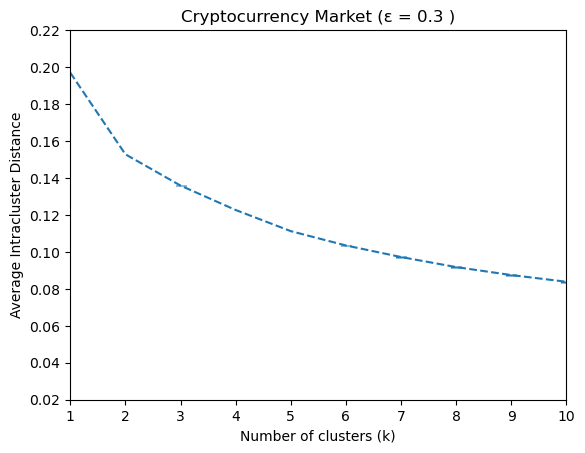

Noise supression is 0.4
matrix shape: (146, 146)
[6.106226635438361e-16, 9.159339953157541e-16, 0.0003367388028121287, 0.00021865522309313067, 0.0002183857151494208, 0.0004486874349816982, 0.0005048604977313657, 0.0005496523758490364, 0.0007035760099682827, 0.0008039232579994711]
k = 2 divded by k= 1
150.0
k = 3 divded by k= 2
36764527196748.84
k = 4 divded by k= 3
64.93318300924219
k = 5 divded by k= 4
99.87674296552473
k = 6 divded by k= 5
205.45640298620427
k = 7 divded by k= 6
112.51941961600924
k = 8 divded by k= 7
108.87212969106257
k = 9 divded by k= 8
128.00381493511853
k = 10 divded by k= 9
114.26246014779724


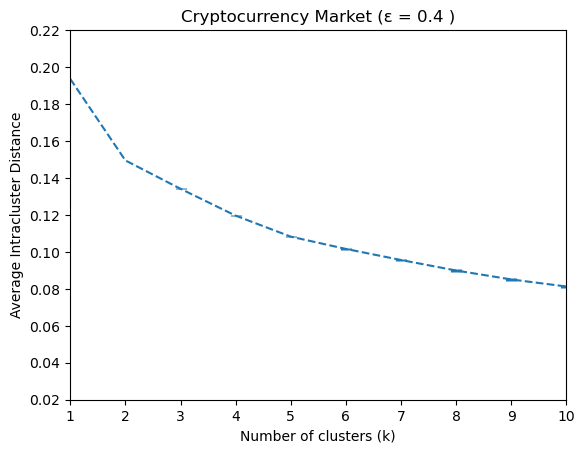

Noise supression is 0.5
matrix shape: (146, 146)
[1.1102230246251565e-16, 8.326672684688674e-16, 0.0002589371992304532, 0.00023630130376821475, 0.00015629119000109304, 0.00032052745779181187, 0.0003319458781863072, 0.00033713907701491964, 0.0004006795498048667, 0.0005734047132397719]
k = 2 divded by k= 1
750.0
k = 3 divded by k= 2
31097319305776.77
k = 4 divded by k= 3
91.2581523514153
k = 5 divded by k= 4
66.1406380365964
k = 6 divded by k= 5
205.0835096908343
k = 7 divded by k= 6
103.56238447500239
k = 8 divded by k= 7
101.56447155090076
k = 9 divded by k= 8
118.84696172052911
k = 10 divded by k= 9
143.10805568165966


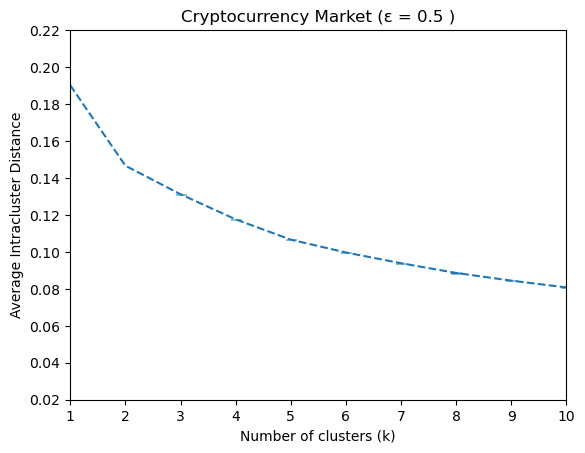

Noise supression is 0.6000000000000001
matrix shape: (146, 146)
[1.970645868709653e-15, 6.38378239159465e-16, 0.00026154099278595045, 0.00018018384113352665, 0.00015634979217926437, 0.00028525175520049034, 0.00047441077341987104, 0.0004975020993930542, 0.0005317882553488958, 0.0006108357027229304]
k = 2 divded by k= 1
32.3943661971831
k = 3 divded by k= 2
40969597135753.6
k = 4 divded by k= 3
68.89315484131092
k = 5 divded by k= 4
86.77237159318861
k = 6 divded by k= 5
182.44460144432566
k = 7 divded by k= 6
166.31300764001594
k = 8 divded by k= 7
104.86736964397443
k = 9 divded by k= 8
106.89166055734647
k = 10 divded by k= 9
114.86445903589448


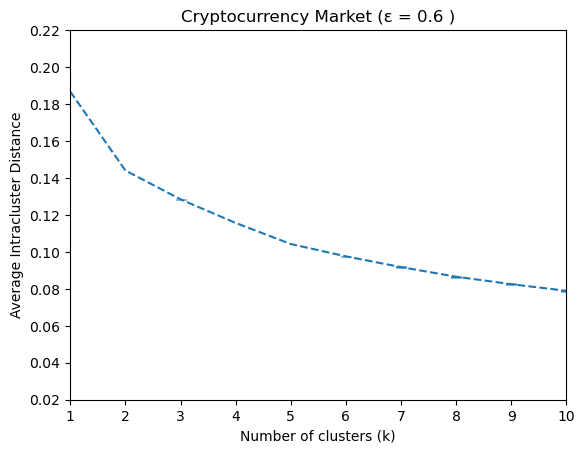

Noise supression is 0.7000000000000001
matrix shape: (146, 146)
[1.0269562977782698e-15, 1.5398156639842465e-05, 0.0003169557378283121, 0.00037884717190367427, 0.0001479982653836106, 0.0004750196304929964, 0.0004388802952717055, 0.00042332147064557237, 0.0005389044502006341, 0.0005160907028876887]
k = 2 divded by k= 1
1499397459575.9363
k = 3 divded by k= 2
2058.4005296334926
k = 4 divded by k= 3
119.52683819495557
k = 5 divded by k= 4
39.065427000532196
k = 6 divded by k= 5
320.9629716008822
k = 7 divded by k= 6
92.3920333179107
k = 8 divded by k= 7
96.45488193620065
k = 9 divded by k= 8
127.30383114723564
k = 10 divded by k= 9
95.76664336238977


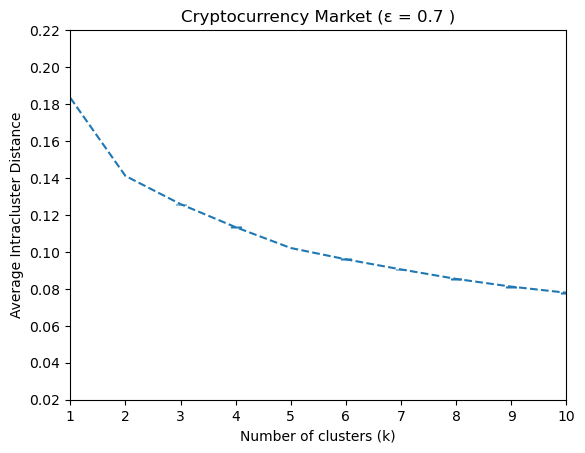

This took 2899.693042039871 seconds 


In [347]:
final = ultimate(rmatrix, np.arange(0,.8,.1))

In [ ]:
# ep0 k = 5 
# ep1 k = 6
# ep2 k = 6
# ep3 k = 5
# ep4 k = 5 
# ep5 k = 5
# ep6 k = 5
# ep7 k = 5
# the correct number of market states is 5 with the lowest std given by ep = 0.3

# Getting All Data for ep = 0.3

In [73]:
# get averages of each R matrix and put them in a list
raverages = list()
for i in range(len(rmatrix)):
    raverages.append(rmatrix[i].mean().mean())
# Get a Correlation Matrix for each R matrix
corrmatrix = [i.corr(method='pearson') for i in rmatrix]
# Get average correlation for each matrix without noise supp 
corraverages = [i.mean().mean() for i in corrmatrix]
# get supressed noise matrices for ep = 0.3
supcorrmatrix = noisesupression(corrmatrix, 0.3)
# Get average correlation for each matrix with noise supp 
supcorraverages = [i.mean().mean() for i in supcorrmatrix]
# Get similarity matrix from supressed corr matrices
simmatrix = getsimmatrix(supcorrmatrix)
# initialize MDS algo and fit it with our similarity matrix
# simtrans gives the new points in a reduced dimension n_components set by the MDS parameters
mds = MDS(n_components = 3, dissimilarity = 'precomputed')
simtrans = mds.fit_transform(simmatrix)
# initialize K-Means clustering algorithm
# take the MDS reduced similarity matrix and use K-means clustering on it with k=5 as determined
km = KMeans(n_clusters=5, init='random')
y_km = km.fit_predict(simtrans)

# Generate All Graphs

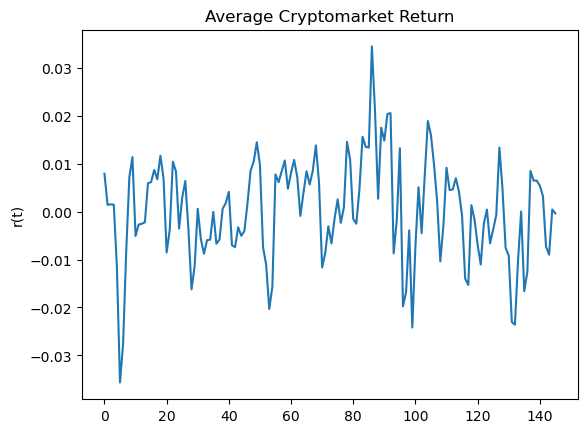

In [74]:
# going to plot r values. python will automatically plot in chronological order given how we constructed our data
labels = np.arange(2018,2022)
plt.style.use('default')
plt.plot(raverages)
plt.ylabel("r(t)")
plt.title('Average Cryptomarket Return')

#plt.locator_params(axis='x', nbins=10)
plt.show()

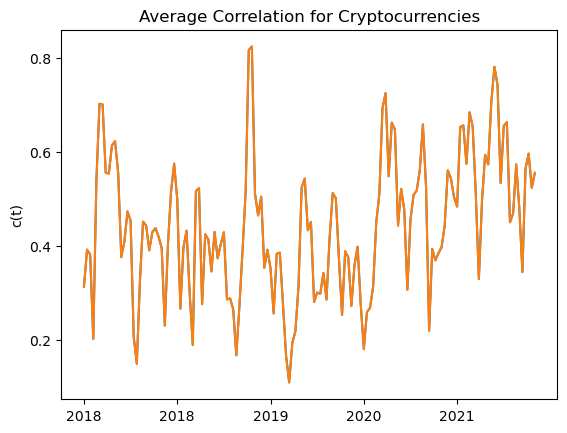

In [131]:
# Plot average correlation 
fig, ax = plt.subplots()
xcorr = np.arange(0,len(corraverages))
plt.style.use('default')
plt.plot(corraverages)
plt.ylabel("c(t)")
plt.title('Average Correlation for Cryptocurrencies')
labels = np.linspace(2018, 2022, num=len(xcorr), dtype=int)
plt.plot(xcorr, corraverages)
plt.xticks(xcorr, labels)
plt.locator_params(nbins=5)

plt.show()

AttributeError: 'PathCollection' object has no property 'zs'

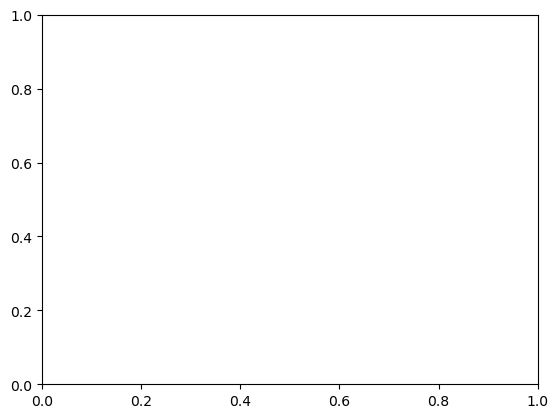

In [87]:
# simple example of what MDS is doing for a 3x3 similarity matrix (3 dimensions) into 2 dimensions
#colors = ['r', 'g', 'b', 'y']
#size = [64, 64, 64, 64]
#fig = plt.figure(2, (10,4))
#ax = fig.add_subplot(121, projection='3d')
#plt.scatter(simmatrix[:,0], simmatrix[:,1], zs=simmatrix[:,2], s=size, c = colors)
#plt.title('Original Points')

#ax = fig.add_subplot(122)
ax = fig.add_subplot(121, projection='3d')
plt.scatter(simtrans[:,0], simtrans[:,1], zs = simtrans[:,2])
plt.title('Embedding in 3D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

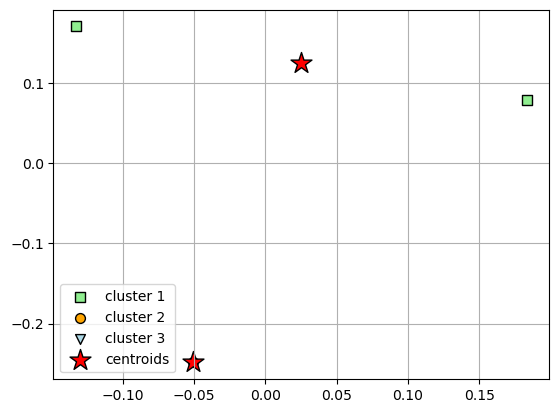

In [26]:
# plotting an example for these 3 points and doing a k=2 means clustering
plt.scatter(
    simtrans[y_km == 0, 0], simtrans[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    simtrans[y_km == 1, 0], simtrans[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    simtrans[y_km == 2, 0], simtrans[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

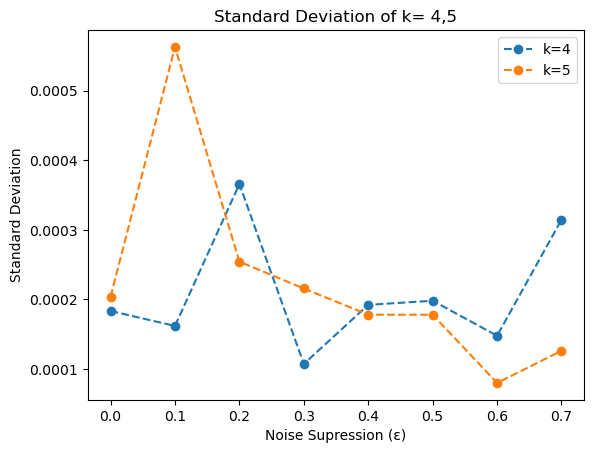

In [279]:
plt.plot(epoints, std4, label = 'k=4', linestyle = '--', marker = 'o')
plt.plot(epoints, std5, label = 'k=5', linestyle = '--', marker = 'o')
plt.title('Standard Deviation of k= 4,5')
plt.ylabel('Standard Deviation')
plt.xlabel('Noise Supression (\u03B5)')
plt.legend()
plt.show()

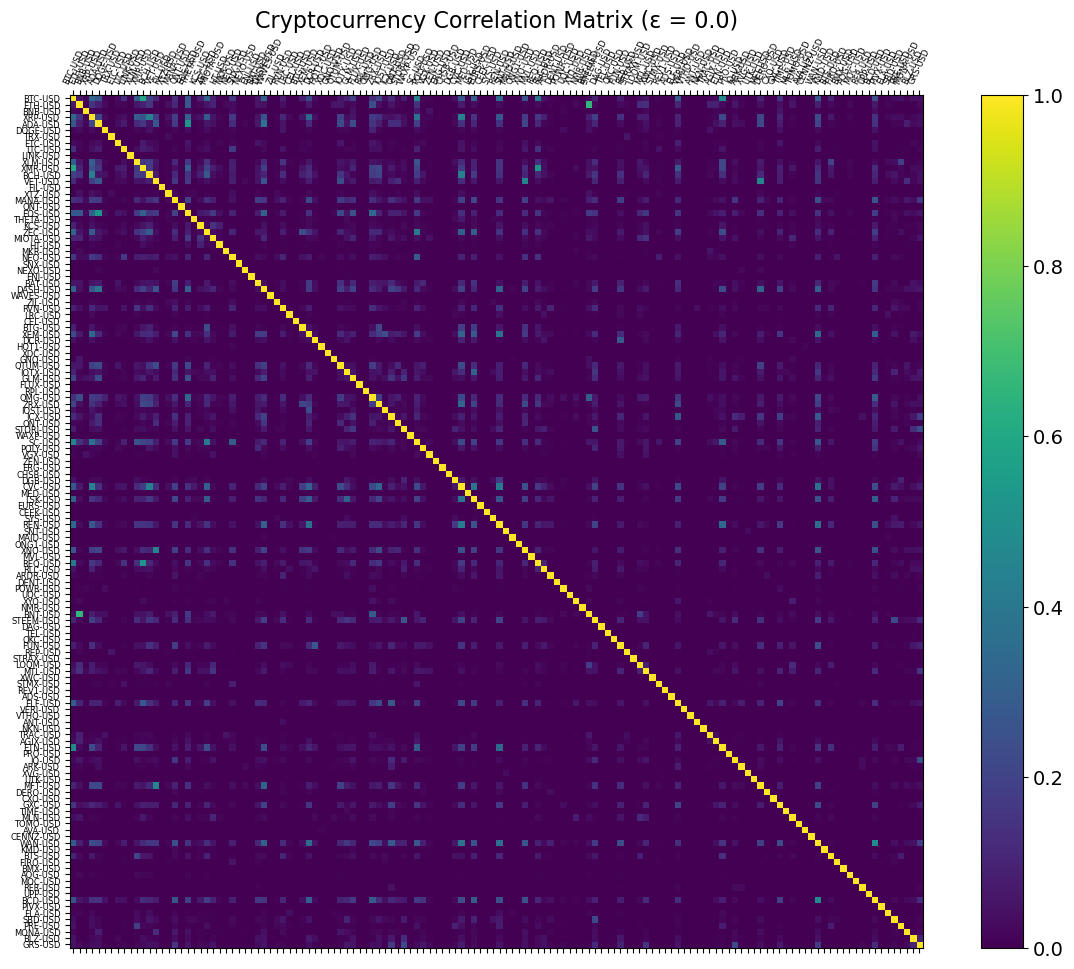

In [312]:
# plot correlation matrix with no noise supression
f = plt.figure(figsize=(15,11))
plt.matshow(corrmatrix[10], fignum=f.number)
plt.xticks(range(rmatrix[10].select_dtypes(['number']).shape[1]), rmatrix[10].select_dtypes(['number']).columns, fontsize=6, rotation=65)
plt.yticks(range(rmatrix[10].select_dtypes(['number']).shape[1]), rmatrix[10].select_dtypes(['number']).columns, fontsize=6)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Cryptocurrency Correlation Matrix (\u03B5 = 0.0)', fontsize=16);

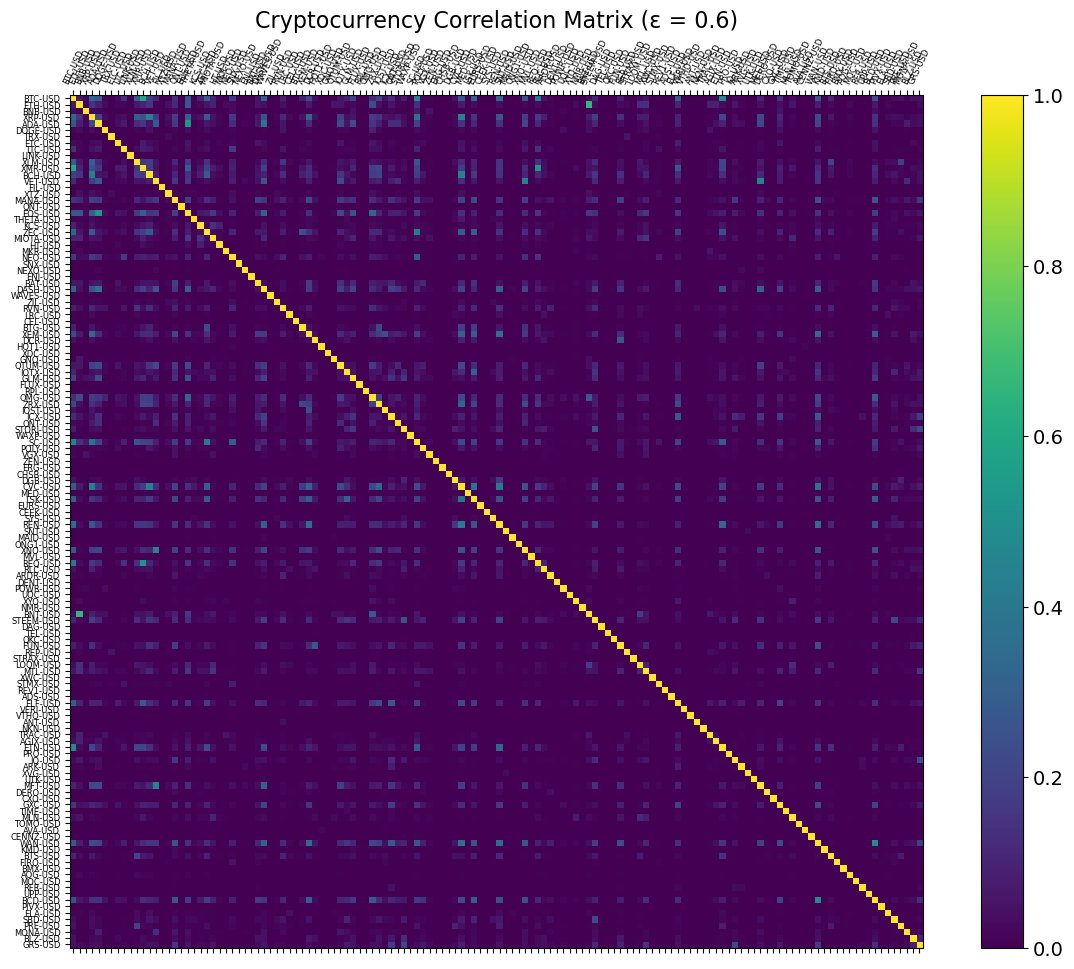

In [313]:
# plot correlation matrix with noise supression
f = plt.figure(figsize=(15,11))
plt.matshow(supcorrmatrix[10], fignum=f.number)
plt.xticks(range(rmatrix[10].select_dtypes(['number']).shape[1]), rmatrix[10].select_dtypes(['number']).columns, fontsize=6, rotation=65)
plt.yticks(range(rmatrix[10].select_dtypes(['number']).shape[1]), rmatrix[10].select_dtypes(['number']).columns, fontsize=6)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Cryptocurrency Correlation Matrix (\u03B5 = 0.6)', fontsize=16);